In [35]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from random import random, randrange, choice, shuffle, randint
from datetime import datetime, timedelta, date
from itertools import combinations
from pprint import pprint
import calendar
import plotly.express as px
import time

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # Cell의 모든 반환값 출력

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [36]:
data_num = "_real3"
블록원데이터 = pd.read_excel(f"D:/공정최적화/data/data{data_num}.xlsx", sheet_name="블록데이터")
정반원데이터 = pd.read_excel(f"D:/공정최적화/data/data{data_num}.xlsx", sheet_name="정반데이터")
블록원데이터.shape, 정반원데이터.shape

샘플개수 = 30
블록원데이터 = 블록원데이터.iloc[:샘플개수,:]
블록원데이터.shape, 정반원데이터.shape

((188, 18), (6, 7))

((30, 18), (6, 7))

In [37]:
블록원데이터.head()

,blk_id,상태,호선번호,블록,서브블록,스테이지,중량,용접장,가로,세로,중_착수일,중_완료일,표준공기,정반명,실_착수일,실_완료일,실_공기,좌상단좌표
0,1,확정,836506,E42S,DK1,41,76,763.7,13.0,13.5,2024-02-19,2024-02-29,10,D1,2024-02-22,2024-03-06,13,NaN
1,2,확정,422406,N22P,SS,45,10,635.9,14.4,10.5,2024-02-26,2024-03-05,8,C1,2024-02-23,2024-03-05,11,NaN
2,3,확정,426506,B16P,TT,41,44,472.1,15.0,7.5,2024-02-29,2024-03-22,22,D1,2024-02-23,2024-03-12,18,NaN
3,4,확정,426506,B16S,TT,41,41,416.8,15.0,7.5,2024-02-29,2024-03-22,22,D2,2024-02-23,2024-03-19,25,NaN
4,5,확정,836506,D61P,UA,41,32,371.0,13.2,16.3,2024-02-27,2024-03-12,14,E1,2024-02-23,2024-03-11,17,NaN


# 함수 정의

## 블록데이터 1차 전처리

In [38]:
import functools
def unpack_df_columns(func):
    @functools.wraps(func)
    def _unpack_df_columns(*args, **kwargs):
        series = args[0]
        return func(*series.values)
    return _unpack_df_columns

@unpack_df_columns
def 블록우선순위구하기(날짜순서, 공기순서, 크기순서):
    global 착수일가중치, 공기가중치, 크기가중치
    result = np.round((날짜순서*float(착수일가중치) + 공기순서*float(공기가중치) + 크기순서*float(크기가중치))/3,1)
    return result

@unpack_df_columns
def 블록사이즈튜플만들기(가로, 세로):
    길이2 = max(가로, 세로)  
    길이1 = min(가로, 세로)
    result = (길이2, 길이1)
    return result

def 블록종류구하기(스테이지):
    if 스테이지 in [41, 42]:
        return "대조립"
    else:
        return "중조립"

def 블록타입구하기(블록):
    return 블록[-1:]

@unpack_df_columns
def get_pair_id(블록종류, 호선번호, 블록):
    result = str(블록종류)+str(호선번호)+블록[:-1]
    return result

@unpack_df_columns
def 계획공기구하기(블록종류, 표준공기):
    if 블록종류 == "대조립":
        return min(7, 표준공기)
    else:
        return min(6, 표준공기)

def 반출일구하기(중_완료일):
    return pd.to_datetime(중_완료일) - timedelta(days=int(3))

@unpack_df_columns
def 최소착수요구일구하기(납기, 공기):
    result = pd.to_datetime(납기) - timedelta(days=int(공기))
    return result.date()

# def 최선조기착수일구하기(최소착수요구일):
#     global 조기착수한계일수
#     return pd.to_datetime(최소착수요구일) - timedelta(days=int(조기착수한계일수))

def 최선조기착수일구하기(중_착수일):
    global 조기착수한계일수
    return pd.to_datetime(중_착수일) - timedelta(days=int(조기착수한계일수))
    
@unpack_df_columns
def E32C세로길이조정하기(블록, 세로):   # E32C 블록은 안전통로 일부 침범하여 세로 배치가능한 점 고려
    if 블록 == "E32C":
        return 세로 - 2
    else:
        return 세로
    
def 블록데이터전처리(블록원데이터):
    블록데이터 = 블록원데이터.copy()
    블록데이터["블록종류"] = 블록데이터["스테이지"].apply(블록종류구하기)
    블록데이터["타입"] = 블록데이터["블록"].apply(블록타입구하기)
    블록데이터["PAIR_ID"] = 블록데이터[["블록종류","호선번호", "블록"]].apply(get_pair_id, axis=1)
    
    블록데이터["가로"] = 블록데이터["가로"].apply(lambda x: np.round(x,0))
    블록데이터["세로"] = 블록데이터["세로"].apply(lambda x: np.round(x,0))
    블록데이터["세로"] = 블록데이터[["블록", "세로"]].apply(E32C세로길이조정하기, axis=1)
    블록데이터["사이즈"] = 블록데이터[["가로", "세로"]].apply(블록사이즈튜플만들기, axis=1)
    블록데이터["면적"] = 블록데이터.eval("가로*세로")
    블록데이터["최대길이"] = 블록데이터["사이즈"].apply(lambda x: max(x))
    블록데이터["최소길이"] = 블록데이터["사이즈"].apply(lambda x: min(x))
    
    블록데이터["중_완료일"] = pd.to_datetime(블록데이터["중_완료일"])
    블록데이터["계획공기"] = 블록데이터[["블록종류", "표준공기"]].apply(계획공기구하기, axis=1)
    블록데이터["반출일"] = 블록데이터["중_완료일"].apply(반출일구하기)
    블록데이터["최소착수요구일"] = 블록데이터[["반출일", "계획공기"]].apply(최소착수요구일구하기, axis=1)
    블록데이터["최선조기착수일"] = 블록데이터["중_착수일"].apply(최선조기착수일구하기)
    
    블록데이터["날짜순서"] = 블록데이터["최소착수요구일"].rank()
    블록데이터["공기순서"] = 블록데이터["표준공기"].rank(ascending=False)
    블록데이터["크기순서"] = 블록데이터["면적"].rank(ascending=False)
    블록데이터["우선순위"] = 블록데이터[["날짜순서", "공기순서", "크기순서"]].apply(블록우선순위구하기, axis=1)
    
    블록데이터 = 블록데이터.sort_values(by=["우선순위"])
    return 블록데이터

In [39]:
착수일가중치, 공기가중치, 크기가중치 = 9, 0.5, 0.5
조기착수한계일수 = 9

블록데이터 = 블록데이터전처리(블록원데이터)
블록데이터.head()

,blk_id,상태,호선번호,블록,서브블록,스테이지,중량,용접장,가로,세로,중_착수일,중_완료일,표준공기,정반명,실_착수일,실_완료일,실_공기,좌상단좌표,블록종류,타입,PAIR_ID,사이즈,면적,최대길이,최소길이,계획공기,반출일,최소착수요구일,최선조기착수일,날짜순서,공기순서,크기순서,우선순위
9,10,확정,836506,E42P,DK1,41,68,684.5,13.0,15.0,2024-02-19,2024-02-29,10,D2,2024-02-26,2024-03-06,9,NaN,대조립,P,대조립836506E42,"(15.0, 13.0)",195.0,15.0,13.0,7,2024-02-26,2024-02-19,2024-02-10,1.5,21.5,9.0,9.6
0,1,확정,836506,E42S,DK1,41,76,763.7,13.0,14.0,2024-02-19,2024-02-29,10,D1,2024-02-22,2024-03-06,13,NaN,대조립,S,대조립836506E42,"(14.0, 13.0)",182.0,14.0,13.0,7,2024-02-26,2024-02-19,2024-02-10,1.5,21.5,14.0,10.4
10,11,확정,836506,E51P,DK,41,91,962.7,13.0,15.0,2024-02-19,2024-03-07,17,E1,2024-02-26,2024-03-08,11,NaN,대조립,P,대조립836506E51,"(15.0, 13.0)",195.0,15.0,13.0,7,2024-03-04,2024-02-26,2024-02-10,5.0,8.0,9.0,17.8
1,2,확정,422406,N22P,SS,45,10,635.9,14.0,10.0,2024-02-26,2024-03-05,8,C1,2024-02-23,2024-03-05,11,NaN,중조립,P,중조립422406N22,"(14.0, 10.0)",140.0,14.0,10.0,6,2024-03-02,2024-02-25,2024-02-17,3.5,25.0,20.0,18.0
8,9,확정,422406,N22S,SS,45,10,639.2,14.0,10.0,2024-02-26,2024-03-05,8,C1,2024-02-26,2024-03-08,11,NaN,중조립,S,중조립422406N22,"(14.0, 10.0)",140.0,14.0,10.0,6,2024-03-02,2024-02-25,2024-02-17,3.5,25.0,20.0,18.0


## 블록데이터 2차 전처리

In [40]:
def get_pair_count(SP_PAIR):
    global 블록데이터
    result = 블록데이터["PAIR_ID"].value_counts()[SP_PAIR]
    return result
    
@unpack_df_columns
def pair_target(블록종류, 블록타입, PAIR_CNT):
    if 블록종류 == "대조립" and 블록타입 in ["P", "S"] and PAIR_CNT == 2:
        return "PAIR"
    else:
        return "SINGLE"

In [41]:
블록데이터["PAIR_CNT"] = 블록데이터["PAIR_ID"].apply(get_pair_count)
블록데이터["PAIR_TARGET"] = 블록데이터[["블록종류", "타입", "PAIR_CNT"]].apply(pair_target, axis=1)
블록데이터.iloc[:,:]

,blk_id,상태,호선번호,블록,서브블록,스테이지,중량,용접장,가로,세로,중_착수일,중_완료일,표준공기,정반명,실_착수일,실_완료일,실_공기,좌상단좌표,블록종류,타입,PAIR_ID,사이즈,면적,최대길이,최소길이,계획공기,반출일,최소착수요구일,최선조기착수일,날짜순서,공기순서,크기순서,우선순위,PAIR_CNT,PAIR_TARGET
9,10,확정,836506,E42P,DK1,41,68,684.5,13.0,15.0,2024-02-19,2024-02-29,10,D2,2024-02-26,2024-03-06,9,NaN,대조립,P,대조립836506E42,"(15.0, 13.0)",195.0,15.0,13.0,7,2024-02-26,2024-02-19,2024-02-10,1.5,21.5,9.0,9.6,2,PAIR
0,1,확정,836506,E42S,DK1,41,76,763.7,13.0,14.0,2024-02-19,2024-02-29,10,D1,2024-02-22,2024-03-06,13,NaN,대조립,S,대조립836506E42,"(14.0, 13.0)",182.0,14.0,13.0,7,2024-02-26,2024-02-19,2024-02-10,1.5,21.5,14.0,10.4,2,PAIR
10,11,확정,836506,E51P,DK,41,91,962.7,13.0,15.0,2024-02-19,2024-03-07,17,E1,2024-02-26,2024-03-08,11,NaN,대조립,P,대조립836506E51,"(15.0, 13.0)",195.0,15.0,13.0,7,2024-03-04,2024-02-26,2024-02-10,5.0,8.0,9.0,17.8,1,SINGLE
1,2,확정,422406,N22P,SS,45,10,635.9,14.0,10.0,2024-02-26,2024-03-05,8,C1,2024-02-23,2024-03-05,11,NaN,중조립,P,중조립422406N22,"(14.0, 10.0)",140.0,14.0,10.0,6,2024-03-02,2024-02-25,2024-02-17,3.5,25.0,20.0,18.0,2,SINGLE
8,9,확정,422406,N22S,SS,45,10,639.2,14.0,10.0,2024-02-26,2024-03-05,8,C1,2024-02-26,2024-03-08,11,NaN,중조립,S,중조립422406N22,"(14.0, 10.0)",140.0,14.0,10.0,6,2024-03-02,2024-02-25,2024-02-17,3.5,25.0,20.0,18.0,2,SINGLE
4,5,확정,836506,D61P,UA,41,32,371.0,13.0,16.0,2024-02-27,2024-03-12,14,E1,2024-02-23,2024-03-11,17,NaN,대조립,P,대조립836506D61,"(16.0, 13.0)",208.0,16.0,13.0,7,2024-03-09,2024-03-02,2024-02-18,6.0,16.5,6.5,21.8,2,PAIR
5,6,확정,836506,D61S,UA,41,33,437.5,13.0,16.0,2024-02-28,2024-03-13,14,E2,2024-02-23,2024-03-12,18,NaN,대조립,S,대조립836506D61,"(16.0, 13.0)",208.0,16.0,13.0,7,2024-03-10,2024-03-03,2024-02-19,8.5,16.5,6.5,29.3,2,PAIR
22,23,미정,838206,B21S,TT1,43,20,401.9,10.0,8.0,2024-03-06,2024-03-12,6,NaN,2024-03-01,2024-03-08,7,NaN,중조립,S,중조립838206B21,"(10.0, 8.0)",80.0,10.0,8.0,6,2024-03-09,2024-03-03,2024-02-26,8.5,29.0,27.5,34.9,3,SINGLE
28,29,미정,838206,B21P,TT1,43,40,405.2,10.0,8.0,2024-03-06,2024-03-12,6,NaN,2024-03-05,2024-03-13,8,NaN,중조립,P,중조립838206B21,"(10.0, 8.0)",80.0,10.0,8.0,6,2024-03-09,2024-03-03,2024-02-26,8.5,29.0,27.5,34.9,3,SINGLE
29,30,미정,838206,B21P,TT2,48,12,241.1,10.0,3.0,2024-03-06,2024-03-12,6,NaN,2024-03-05,2024-03-13,8,NaN,중조립,P,중조립838206B21,"(10.0, 3.0)",30.0,10.0,3.0,6,2024-03-09,2024-03-03,2024-02-26,8.5,29.0,30.0,35.3,3,SINGLE


In [42]:
# 블록데이터["PAIR_CNT"].value_counts()

In [43]:
블록데이터[블록데이터["PAIR_TARGET"]=="PAIR"]

,blk_id,상태,호선번호,블록,서브블록,스테이지,중량,용접장,가로,세로,중_착수일,중_완료일,표준공기,정반명,실_착수일,실_완료일,실_공기,좌상단좌표,블록종류,타입,PAIR_ID,사이즈,면적,최대길이,최소길이,계획공기,반출일,최소착수요구일,최선조기착수일,날짜순서,공기순서,크기순서,우선순위,PAIR_CNT,PAIR_TARGET
9,10,확정,836506,E42P,DK1,41,68,684.5,13.0,15.0,2024-02-19,2024-02-29,10,D2,2024-02-26,2024-03-06,9,NaN,대조립,P,대조립836506E42,"(15.0, 13.0)",195.0,15.0,13.0,7,2024-02-26,2024-02-19,2024-02-10,1.5,21.5,9.0,9.6,2,PAIR
0,1,확정,836506,E42S,DK1,41,76,763.7,13.0,14.0,2024-02-19,2024-02-29,10,D1,2024-02-22,2024-03-06,13,NaN,대조립,S,대조립836506E42,"(14.0, 13.0)",182.0,14.0,13.0,7,2024-02-26,2024-02-19,2024-02-10,1.5,21.5,14.0,10.4,2,PAIR
4,5,확정,836506,D61P,UA,41,32,371.0,13.0,16.0,2024-02-27,2024-03-12,14,E1,2024-02-23,2024-03-11,17,NaN,대조립,P,대조립836506D61,"(16.0, 13.0)",208.0,16.0,13.0,7,2024-03-09,2024-03-02,2024-02-18,6.0,16.5,6.5,21.8,2,PAIR
5,6,확정,836506,D61S,UA,41,33,437.5,13.0,16.0,2024-02-28,2024-03-13,14,E2,2024-02-23,2024-03-12,18,NaN,대조립,S,대조립836506D61,"(16.0, 13.0)",208.0,16.0,13.0,7,2024-03-10,2024-03-03,2024-02-19,8.5,16.5,6.5,29.3,2,PAIR
14,15,미정,422706,B31S,SS,42,74,818.9,16.0,12.0,2024-02-27,2024-03-15,17,NaN,2024-02-28,2024-03-19,20,NaN,대조립,S,대조립422706B31,"(16.0, 12.0)",192.0,16.0,12.0,7,2024-03-12,2024-03-05,2024-02-18,14.0,8.0,11.5,45.2,2,PAIR
23,24,미정,422706,B31P,SS,42,74,818.9,16.0,12.0,2024-02-27,2024-03-15,17,NaN,2024-03-04,2024-03-18,14,NaN,대조립,P,대조립422706B31,"(16.0, 12.0)",192.0,16.0,12.0,7,2024-03-12,2024-03-05,2024-02-18,14.0,8.0,11.5,45.2,2,PAIR
15,16,미정,422706,S19S,SS,42,27,345.4,13.0,9.0,2024-03-07,2024-03-18,11,NaN,2024-02-28,2024-03-14,15,NaN,대조립,S,대조립422706S19,"(13.0, 9.0)",117.0,13.0,9.0,7,2024-03-15,2024-03-08,2024-02-27,18.5,19.5,24.5,62.8,2,PAIR
21,22,미정,422706,S19P,SS,42,28,348.0,13.0,9.0,2024-03-07,2024-03-18,11,NaN,2024-03-01,2024-03-15,14,NaN,대조립,P,대조립422706S19,"(13.0, 9.0)",117.0,13.0,9.0,7,2024-03-15,2024-03-08,2024-02-27,18.5,19.5,24.5,62.8,2,PAIR
6,7,확정,836506,S18P,SS,41,89,840.6,13.0,14.0,2024-02-29,2024-03-20,20,E1,2024-02-23,2024-03-15,21,NaN,대조립,P,대조립836506S18,"(14.0, 13.0)",182.0,14.0,13.0,7,2024-03-17,2024-03-10,2024-02-20,24.0,5.0,14.0,75.2,2,PAIR
7,8,확정,836506,S18S,SS,41,89,824.7,13.0,14.0,2024-02-29,2024-03-20,20,E2,2024-02-23,2024-03-20,26,NaN,대조립,S,대조립836506S18,"(14.0, 13.0)",182.0,14.0,13.0,7,2024-03-17,2024-03-10,2024-02-20,24.0,5.0,14.0,75.2,2,PAIR


## 정반데이터 전처리 함수

In [44]:
@unpack_df_columns
def 정반사이즈튜플만들기(가로, 세로):
    길이1 = max(가로, 세로)  
    길이2 = min(가로, 세로)
    result = (길이1, 길이2)
    return result

def 정반데이터전처리(정반원데이터):
    df = 정반원데이터.copy()
    df["사이즈"] = df[["가로", "세로"]].apply(정반사이즈튜플만들기, axis=1)
    df["최대길이"] = df["사이즈"].apply(lambda x: max(x))
    df["최소길이"] = df["사이즈"].apply(lambda x: min(x))
    return df

In [45]:
중량가중치, 크기가중치 = 0.5, 0.5
정반데이터 = 정반데이터전처리(정반원데이터)
정반데이터

,id,정반그룹,정반명,가능중량,가로,세로,반출한계사이즈,사이즈,최대길이,최소길이
0,1,C,C1,200,44,13,15,"(44, 13)",44,13
1,2,C,C2,200,31,13,15,"(31, 13)",31,13
2,3,D,D1,200,43,26,15,"(43, 26)",43,26
3,4,D,D2,200,41,26,15,"(41, 26)",41,26
4,5,E,E1,200,42,26,20,"(42, 26)",42,26
5,6,E,E2,200,41,27,20,"(41, 27)",41,27


## 물리조건 체크 함수 (길이조건)

In [46]:
def 반출한계사이즈체크(blk_id):  # 블록의 최소길이가 정반의 반출한계사이즈보다 작고
    가능정반리스트 = []
    블록최소길이 = 블록데이터[블록데이터["blk_id"]==blk_id]["최소길이"].values[0]
    for 정반명 in 정반데이터["정반명"]:
        반출한계사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["반출한계사이즈"].values[0]
        if 반출한계사이즈 > 블록최소길이:
            가능정반리스트.append(정반명)
    return 가능정반리스트

def 정반최대길이체크(blk_id, 정반리스트):  # 블록의 최대길이가 정반최대길이보다 작고
    가능정반리스트 = []
    블록최대길이 = 블록데이터[블록데이터["blk_id"]==blk_id]["최대길이"].values[0]
    for 정반명 in 정반리스트:
        정반최대길이 = 정반데이터[정반데이터["정반명"]==정반명]["최대길이"].values[0]
        if 정반최대길이 >= 블록최대길이:
            가능정반리스트.append(정반명)
    return 가능정반리스트

In [47]:
sample_id = 15
반출한계가능정반 = 반출한계사이즈체크(sample_id)
print(반출한계가능정반)
정반최대길이가능정반 = 정반최대길이체크(sample_id, 반출한계가능정반)
print(정반최대길이가능정반)

['C1', 'C2', 'D1', 'D2', 'E1', 'E2']
['C1', 'C2', 'D1', 'D2', 'E1', 'E2']


## 블록종류 체크 함수

In [48]:
def 블록종류체크(blk_id, 정반리스트):   # 블록종류가 중조립이면, E정반 배치 불가
    filtered_list = 정반리스트.copy()
    블록종류 = 블록데이터[블록데이터["blk_id"]==blk_id]["블록종류"].values[0]
    블록 = 블록데이터[블록데이터["blk_id"]==blk_id]["블록"].values[0]
    
    if 블록종류 == "중조립" and 블록 not in ["E32P", "E32S"]:   # 중조블록이면, E그룹 정반 제외. 단, E32P E32S는 E그룹 가능
        filtered_list = [item for item in 정반리스트 if item not in ('E1', 'E2')]
    elif 블록종류 == "대조립":  # 대조블록이면 C그룹 정반 제외
        filtered_list = [item for item in 정반리스트 if item not in ('C1', 'C2')]
    return filtered_list

In [49]:
블록종류체크정반 = 블록종류체크(sample_id, 정반최대길이가능정반)
블록종류체크정반

['D1', 'D2', 'E1', 'E2']

# 레이아웃 배치 함수

In [50]:
def init_jungban(사이즈):  #사이즈 = (10, 10)
    surface_width, surface_height = 사이즈[0], 사이즈[1]  # Adjusted to match the provided image for demonstration
    surface = np.zeros((surface_height, surface_width), dtype=int)
    return surface, surface_width, surface_height

def can_place_with_thresh(surface, surface_width, surface_height, block_height, block_width, start_row, start_col, thresh):
    new_width = int(surface_width - thresh)
    new_height = int(surface_height - thresh)
    
    if start_row + block_height > surface_height or start_col + block_width > surface_width:
        return False

    block_area = surface[int(start_row):int(start_row+block_height), int(start_col):int(start_col+block_width)]
    if np.any(block_area != 0):
        return False
    
    if start_row > 0 and np.any(surface[int(start_row-thresh): int(start_row),int(start_col):int(start_col+block_width)] != 0):
        return False
    if start_col > 0 and np.any(surface[int(start_row): int(start_row+block_height), int(start_col-thresh): int(start_col)] != 0):
        return False
    
    return True

# Function to place a block on the surface, if possible
def place_block(surface, block_height, block_width, start_row, start_col, block_id):
    block_height, block_width = block_height, block_width
    surface[int(start_row):int(start_row + block_height), int(start_col):int(start_col + block_width)] = block_id
    return surface


def 레이아웃배치(surface, surface_width, surface_height, block_height, block_width, block_id, thresh):
    
    best_fit_score = float('inf')
    best_position = None
    surface_height = int(surface_height)
    block_height = int(block_height)
    loop_num = int(surface_height - block_height + 1)
    
    for start_row in range(loop_num):
        for start_col in range(loop_num):
            if can_place_with_thresh(surface, surface_width, surface_height, block_height, block_width, start_row, start_col, thresh):
                # Calculate a score; here we use the top-left corner (y, x) as the score
                # A lower score means the block is closer to the top-left
                score = start_row + start_col
                if score < best_fit_score:
                    best_fit_score = score
                    best_position = (start_row, start_col)
    
    if best_position:
        surface = place_block(surface, block_height, block_width, *best_position, block_id)
        return True, surface
    else:
        return False, surface

def get_overlapped_surface(*arrays):
    result = arrays[0]
    for arr in arrays[1:]:
        result = np.add(result, arr)
    return result

# 특정 값만 남기고 다 지운후에 그 결과를 다시 각 해당일 surface에 더해준다...천재네..ㅋ
def extract_newblock_layout_only(overlapped_surface, block_id):
    mask = overlapped_surface != block_id
    overlapped_surface[mask] = 0
    newblock_layout = overlapped_surface
    return newblock_layout

In [51]:
# def draw_layout(레이아웃달력, 정반, idx):
#     target_date = 레이아웃달력.index[idx]
#     target_surface = 레이아웃달력.at[target_date, 정반]
#     fig, ax = plt.subplots(figsize=(8, 6))
#     plt.imshow(target_surface, cmap="Blues", interpolation='nearest')
    
#     for i in range(len(target_surface)):
#         for j in range(len(target_surface[0])):
#             plt.text(j, i, f'{target_surface[i, j]}', ha='center', va='center', color='white', fontsize=7)
#     # plt.colorbar()  # Add a color bar to show the mapping of values to colors
#     plt.show()

In [66]:
def draw_layout_6_subplots(레이아웃달력, 정반리스트, idx):
    정반1 = 정반리스트[0]
    정반2 = 정반리스트[1]
    정반3 = 정반리스트[2]
    정반4 = 정반리스트[3]
    정반5 = 정반리스트[4]
    정반6 = 정반리스트[5]
    
    target_date = 레이아웃달력.index[idx]
    print(target_date)
    target_surface1 = 레이아웃달력.at[target_date, 정반1]
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(20, 15))
    
    ax = axs[0]
    ax.imshow(target_surface1, cmap="Accent", interpolation='nearest')
    for i in range(len(target_surface1)):
        for j in range(len(target_surface1[0])):
            ax.text(j, i, f'{target_surface1[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반1}')  # Set subplot title
    
    target_surface2 = 레이아웃달력.at[target_date, 정반2]
    ax = axs[1]
    ax.imshow(target_surface2, cmap="Accent", interpolation='nearest')
    for i in range(len(target_surface2)):
        for j in range(len(target_surface2[0])):
            ax.text(j, i, f'{target_surface2[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반2}')  # Set subplot title

    target_surface3 = 레이아웃달력.at[target_date, 정반3]
    ax = axs[2]
    ax.imshow(target_surface3, cmap="Accent", interpolation='nearest')
    for i in range(len(target_surface3)):
        for j in range(len(target_surface3[0])):
            ax.text(j, i, f'{target_surface3[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반3}')  # Set subplot title


    target_surface4 = 레이아웃달력.at[target_date, 정반4]
    ax = axs[3]
    ax.imshow(target_surface4, cmap="Accent", interpolation='nearest')
    for i in range(len(target_surface4)):
        for j in range(len(target_surface4[0])):
            ax.text(j, i, f'{target_surface4[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반4}')  # Set subplot title


    target_surface5 = 레이아웃달력.at[target_date, 정반5]
    ax = axs[4]
    ax.imshow(target_surface5, cmap="Accent", interpolation='nearest')
    for i in range(len(target_surface5)):
        for j in range(len(target_surface5[0])):
            ax.text(j, i, f'{target_surface5[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반5}')  # Set subplot title

    target_surface6 = 레이아웃달력.at[target_date, 정반6]
    ax = axs[5]
    ax.imshow(target_surface6, cmap="Accent", interpolation='nearest')
    for i in range(len(target_surface6)):
        for j in range(len(target_surface6[0])):
            ax.text(j, i, f'{target_surface6[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반6}')  # Set subplot title
    
    plt.tight_layout()  # Adjust subplot layout
    plt.show()

In [53]:
def 기배치블록배치레이아웃(정반사이즈, 좌상단꼭지점좌표, 블록사이즈, blk_id):
    정반어레이 = np.zeros((정반사이즈[0], 정반사이즈[1]))
    x, y = 좌상단꼭지점좌표
    x = max(x-1, 0)
    y = max(y-1, 0)
    for i in range(블록사이즈[1]):
        for j in range(블록사이즈[0]):
            정반어레이[i+x, j+y] = int(blk_id)   
    return 정반어레이   

# 레이아웃 달력 업데이트

In [54]:
def update_레이아웃달력_기배치블록(레이아웃달력, 정반명, blk_id, 정반데이터, 블록데이터, 조기착수금지일, thresh):

    착수일 = 블록데이터[블록데이터["blk_id"]==blk_id]["실_착수일"].values[0]
    종료일 = 블록데이터[블록데이터["blk_id"]==blk_id]["실_완료일"].values[0]
    계획공기 = int(블록데이터[블록데이터["blk_id"]==blk_id]["계획공기"].values[0])
    블록사이즈 = 블록데이터[블록데이터["blk_id"]==blk_id]["사이즈"].values[0]
    정반사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    surface_width, surface_height = 정반사이즈[0], 정반사이즈[1]
    block_width, block_height = 블록사이즈[0], 블록사이즈[1]
    
    날짜리스트 = [d.strftime("%Y-%m-%d") for d in 레이아웃달력.index]
    start_date = 착수일 # datetime.strptime(최소착수요구일, "%Y-%m-%d").date()
    min_start_date = start_date
    
    end_date = 종료일
    min_start_date= np.datetime_as_string(min_start_date, unit='D') #min_start_date#.strftime('%Y-%m-%d')
    end_date = np.datetime_as_string(end_date, unit='D')#end_date#.strftime('%Y-%m-%d')
    min_start_idx = 날짜리스트.index(min_start_date)
    end_idx = 날짜리스트.index(end_date)
    

    for k in range(1):      
        target_surfaces = []
        temp_dates = []
        for idx in range(min_start_idx, end_idx+1): 
            target_date = 레이아웃달력.index[idx]    # 대상인덱스의 날짜 불러오기
            temp_dates.append(target_date)
            target_surface = 레이아웃달력.at[target_date, 정반명]  # 조회날짜의 레이아웃(서페이스) 불러오기
            target_surfaces.append(target_surface)   # 조회날짜의 레이아웃들을 리스트로 담기
                
        overlapped_surface = get_overlapped_surface(*target_surfaces)  # 리스트에 담은 레이아웃을 합하여 오버랩 레이아웃 생성
        
        bool_res, surface = 레이아웃배치(overlapped_surface, surface_width, surface_height, block_width, block_height, blk_id, thresh)  # 오버랩 레이아웃에 신규 블록 레이아웃 배치검토
        
        if bool_res:  # 신규블록이 배치되어 True라면...
            newblock_layout = extract_newblock_layout_only(surface, int(blk_id))  # 신규배치블록의 레이아웃만 추출 (기배치 다른 블록 레이아웃 제거)
            
            for idx in range(min_start_idx, end_idx+1):   # 조회기간 다시 탐색 (레이아웃 업데이트를 위해)
                target_date = 레이아웃달력.index[idx]  
                target_surface = 레이아웃달력.at[target_date, 정반명]    # 조회일의 레이아웃 불러오기
                target_surface = target_surface + newblock_layout        # 조회일의 레이아웃에 새블록 레이아웃 더하여 내용 합치기
                레이아웃달력.at[target_date, 정반명] = target_surface   # 해당일의 레이아웃을 새레이아웃으로 변경하기 (업데이트 완료)
            
            최선배치일 = temp_dates[0].strftime('%Y-%m-%d')
            최선정반 = 정반명
            break

        else:
            # 가로세로 바꿔서
            bool_res, surface = 레이아웃배치(overlapped_surface, surface_width, surface_height, block_height, block_width, blk_id, thresh)  

            if bool_res:
                newblock_layout = extract_newblock_layout_only(surface, int(blk_id))  # 신규배치블록의 레이아웃만 추출 (기배치 다른 블록 레이아웃 제거)
            
                for idx in range(min_start_idx, end_idx+1):   # 조회기간 다시 탐색 (레이아웃 업데이트를 위해)
                    target_date = 레이아웃달력.index[idx]  
                    target_surface = 레이아웃달력.at[target_date, 정반명]    # 조회일의 레이아웃 불러오기
                    target_surface = target_surface + newblock_layout        # 조회일의 레이아웃에 새블록 레이아웃 더하여 내용 합치기
                    레이아웃달력.at[target_date, 정반명] = target_surface   # 해당일의 레이아웃을 새레이아웃으로 변경하기 (업데이트 완료)
            
                최선배치일 = temp_dates[0].strftime('%Y-%m-%d')
                최선정반 = 정반명
                break

            else:  # 신규블록 배치가 False라면.. 계속 순환
                최선배치일 = None
                최선정반 = None
        
        
    return 레이아웃달력, 최선정반, 최선배치일

In [55]:
def get_end_date_of_month(year, month):
    # Get the number of days in the given month
    num_days = calendar.monthrange(year, month)[1]
    # Return the last day of the month as a datetime object
    return date(year, month, num_days)

def create_레이아웃달력(시작년:int, 시작월:int, 시작일: int, 종료년:int, 종료월:int, 정반데이터:pd.DataFrame) -> pd.DataFrame:
    start_date = datetime(시작년, 시작월, 시작일)
    end_date = get_end_date_of_month(종료년, 종료월)
    정반집합 = 정반데이터["정반명"].tolist()
    날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
    
    달력 = pd.DataFrame()
    달력.index = 날짜집합
    
    for 정반 in 정반집합:
        정반사이즈 = 정반데이터[정반데이터["정반명"]==정반]["사이즈"].values[0]
        # print(f"{정반}정반사이즈: {정반사이즈}")
        surface, surface_width, surface_height = init_jungban(정반사이즈)
        달력[정반] = [surface for _ in range(len(날짜집합))]
        
    return 달력

In [56]:
def update_레이아웃달력(레이아웃달력, 정반명, blk_id, 정반데이터, 블록데이터, 조기착수금지일, thresh, 후퇴배수):

    최소착수요구일 = 블록데이터[블록데이터["blk_id"]==blk_id]["최소착수요구일"].values[0]
    최선조기착수일 = 블록데이터[블록데이터["blk_id"]==blk_id]["최선조기착수일"].values[0]

    
    계획공기 = int(블록데이터[블록데이터["blk_id"]==blk_id]["계획공기"].values[0])
    블록사이즈 = 블록데이터[블록데이터["blk_id"]==blk_id]["사이즈"].values[0]
    정반사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    surface_width, surface_height = 정반사이즈[0], 정반사이즈[1]
    block_width, block_height = 블록사이즈[0], 블록사이즈[1]
    최선배치일 = ""
    
    날짜리스트 = [d.strftime("%Y-%m-%d") for d in 레이아웃달력.index]

    start_date = np.datetime_as_string(최선조기착수일, unit='D')
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    start_date = start_date.date()

    min_start_date = start_date #start_date - timedelta(days=0) 
    end_date = min_start_date + timedelta(days=계획공기)
    min_start_date= min_start_date.strftime('%Y-%m-%d')
    end_date = end_date.strftime('%Y-%m-%d')
    min_start_idx = 날짜리스트.index(min_start_date)
    end_idx = 날짜리스트.index(end_date)
    
    # 레이아웃 순환 검토 
    for k in range(후퇴배수):  
        print(f">>>>> {정반명} {blk_id} - 검토차수{k} / {레이아웃달력.index[min_start_idx].strftime('%Y-%m-%d')}: 조회인덱스범위: {min_start_idx} ~ {end_idx}")
    
        target_surfaces = []
        temp_dates = []
        for idx in range(min_start_idx, end_idx+1): 
            target_date = 레이아웃달력.index[idx]    # 대상인덱스의 날짜 불러오기
            temp_dates.append(target_date)
            target_surface = 레이아웃달력.at[target_date, 정반명]  # 조회날짜의 레이아웃(서페이스) 불러오기
            target_surfaces.append(target_surface)   # 조회날짜의 레이아웃들을 리스트로 담기
                
        overlapped_surface = get_overlapped_surface(*target_surfaces)  # 리스트에 담은 레이아웃을 합하여 오버랩 레이아웃 생성
        bool_res, surface = 레이아웃배치(overlapped_surface, surface_width, surface_height, block_width, block_height, blk_id, thresh)  # 오버랩 레이아웃에 신규 블록 레이아웃 배치검토
        
        if bool_res:  # 신규블록이 배치되어 True라면...
            newblock_layout = extract_newblock_layout_only(surface, int(blk_id))  # 신규배치블록의 레이아웃만 추출 (기배치 다른 블록 레이아웃 제거)
            
            for idx in range(min_start_idx, end_idx+1):   # 조회기간 다시 탐색 (레이아웃 업데이트를 위해)
                target_date = 레이아웃달력.index[idx]  
                target_surface = 레이아웃달력.at[target_date, 정반명]    # 조회일의 레이아웃 불러오기
                target_surface = target_surface + newblock_layout        # 조회일의 레이아웃에 새블록 레이아웃 더하여 내용 합치기
                레이아웃달력.at[target_date, 정반명] = target_surface   # 해당일의 레이아웃을 새레이아웃으로 변경하기 (업데이트 완료)
            
            최선배치일 = temp_dates[0].strftime('%Y-%m-%d')
            정반명 = 정반명
            return 레이아웃달력, 정반명, 최선배치일
            break

        else:
            # 가로세로 바꿔서
            bool_res, surface = 레이아웃배치(overlapped_surface, surface_width, surface_height, block_height, block_width, blk_id, thresh)  

            if bool_res:
                newblock_layout = extract_newblock_layout_only(surface, int(blk_id))  # 신규배치블록의 레이아웃만 추출 (기배치 다른 블록 레이아웃 제거)
            
                for idx in range(min_start_idx, end_idx+1):   # 조회기간 다시 탐색 (레이아웃 업데이트를 위해)
                    target_date = 레이아웃달력.index[idx]  
                    target_surface = 레이아웃달력.at[target_date, 정반명]    # 조회일의 레이아웃 불러오기
                    target_surface = target_surface + newblock_layout        # 조회일의 레이아웃에 새블록 레이아웃 더하여 내용 합치기
                    레이아웃달력.at[target_date, 정반명] = target_surface   # 해당일의 레이아웃을 새레이아웃으로 변경하기 (업데이트 완료)
            
                최선배치일 = temp_dates[0].strftime('%Y-%m-%d')
                정반명 = 정반명
                
                return 레이아웃달력, 정반명, 최선배치일
                break

            else:  # 신규블록 배치가 False라면.. 계속 순환
                min_start_idx += 1
                end_idx += 1
                # pass
    
    print("--------------- 배치가능한 레이아웃이 없습니다.")
    return 레이아웃달력, None, None

In [57]:
def find_earlier(data):
    try:
        data = {key: value for key, value in data.items() if value is not None}
        earliest_date = min(data.values())
        earliest_items = [(key, value) for key, value in data.items() if value == earliest_date]
        earliest_item = choice(earliest_items)
        return earliest_item
    except:
        return None, None

In [58]:
레이아웃달력 = create_레이아웃달력(2023, 10, 1, 2023, 12, 정반데이터)
레이아웃달력.head(3)

,C1,C2,D1,D2,E1,E2
2023-10-01,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2023-10-02,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2023-10-03,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# 시뮬레이션

In [68]:
data_num = "_real3"
착수일가중치, 공기가중치, 크기가중치 = 0.9, 0.01, 0.05
조기착수금지, 블록간격, 후퇴계수 = 7, 0, 15

블록원데이터 = pd.read_excel(f"D:/공정최적화/data/data{data_num}.xlsx", sheet_name="블록데이터")
정반원데이터 = pd.read_excel(f"D:/공정최적화/data/data{data_num}.xlsx", sheet_name="정반데이터")
블록원데이터.shape, 정반원데이터.shape

블록데이터 = 블록데이터전처리(블록원데이터)
블록데이터["PAIR_CNT"] = 블록데이터["PAIR_ID"].apply(get_pair_count)
블록데이터["PAIR_TARGET"] = 블록데이터[["블록종류", "타입", "PAIR_CNT"]].apply(pair_target, axis=1)
정반데이터 = 정반데이터전처리(정반원데이터)

# 블록데이터 = 블록데이터[블록데이터["PAIR_TARGET"]=="PAIR"]  ## PAIR만 검토
검토개수 = 188
블록데이터 = 블록데이터.iloc[:검토개수,:]
블록데이터.shape
블록데이터.head(1)
# -----------------------------------------------------------------------------------------
시작년, 시작월, 시작일, 종료년, 종료월 = 2024, 2, 1, 2024, 5
레이아웃달력 = create_레이아웃달력(시작년, 시작월, 시작일, 종료년, 종료월, 정반데이터)
#-------------------------------------------------------------------------------------------------------------
for _ in tqdm(range(1)):
    
    #기배치 확정 블록 깔기--------------------------------------------------------------------------------------------------------------
    기배치블록리스트 = 블록데이터[블록데이터["상태"]=="확정"]["blk_id"].tolist()
    print(f"기배치블록 ids: {기배치블록리스트}")
    for _ in tqdm(range(len(기배치블록리스트))):
        target_block = 기배치블록리스트[0]
        print(f"기배치검토블록: {target_block}")
        정반명 = 블록데이터[블록데이터["blk_id"]==target_block]["정반명"].values[0]
        레이아웃달력, 최선정반, 최선배치일 = update_레이아웃달력_기배치블록(레이아웃달력, 정반명, target_block, 정반데이터, 블록데이터, 0, 1)
        기배치블록리스트.remove(target_block)
    print("기배치블록 완료-------------------------------------------------------------------------")
    
    #미정 블록 검토 시작------------------------------------------------------------------------------------------- 
    검토블록데이터 = 블록데이터[블록데이터["상태"]=="미정"]
    블록리스트 = 검토블록데이터["blk_id"].tolist()
    정반리스트 = 정반데이터["정반명"].tolist()

    최종결과_블록 = []
    최종결과_정반 = []
    최종결과_착수일자 = []
    
    for _ in tqdm(range(len(블록리스트))):
        target_block = 블록리스트[0]
        블록 = 블록데이터[블록데이터["blk_id"]==target_block]["블록"].values[0]
        블록종류 = 블록데이터[블록데이터["blk_id"]==target_block]["블록종류"].values[0]
        중_착수일 = 블록데이터[블록데이터["blk_id"]==target_block]["중_착수일"].values[0]
        최선조기착수일 = 블록데이터[블록데이터["blk_id"]==target_block]["최선조기착수일"].values[0]
        최소착수요구일 = 블록데이터[블록데이터["blk_id"]==target_block]["최소착수요구일"].values[0]
        반출일 = 블록데이터[블록데이터["blk_id"]==target_block]["반출일"].values[0]
        PAIR_TARGET = 블록데이터[블록데이터["blk_id"]==target_block]["PAIR_TARGET"].values[0]
        PAIR_ID = 블록데이터[블록데이터["blk_id"]==target_block]["PAIR_ID"].values[0]
        print()
        print(f"***** 검토대상: {target_block}-{블록}-{블록종류} | 중_착수일: {np.datetime_as_string(중_착수일, unit='D')}, 최선조기착수일: {np.datetime_as_string(최선조기착수일, unit='D')}  최소착수요구일:{최소착수요구일}, 반출일:{np.datetime_as_string(반출일, unit='D')} ---------------------------------------------")

        # 물리조건 체크
        반출한계가능정반 = 반출한계사이즈체크(target_block)
        # print(f"반출한계가능정반: {반출한계가능정반}")
        정반최대길이가능정반 = 정반최대길이체크(target_block, 반출한계가능정반)
        # print(f"정반최대길이가능정반: {정반최대길이가능정반}")
        블록종류체크정반 = 블록종류체크(target_block, 정반최대길이가능정반)
        print(f"블록종류체크정반: {블록종류체크정반}")

        ## PAIR 블록인지 먼저 체크
        if PAIR_TARGET == "PAIR":
            PAIR_BLOCK_IDS = 블록데이터[블록데이터["PAIR_ID"]==PAIR_ID]["blk_id"].values
            blk_id1, blk_id2 = min(PAIR_BLOCK_IDS), max(PAIR_BLOCK_IDS)
            print(f"+++ PAIR 블록입니다.- PAIR_BLOCK_IDS: {PAIR_BLOCK_IDS}, blk_id1:{blk_id1}, blk_id2:{blk_id2}")
            정반그룹= [블록종류체크정반[i:i+2] for i in range(0, len(블록종류체크정반), 2)]
            print(f"PAIR_TARGET: {PAIR_TARGET}, PAIR_ID: {PAIR_ID} | blk_id1: {blk_id1}, blk_id2: {blk_id2} - 정반그룹: {정반그룹}")
            
            가능정반들 = 블록종류체크정반
            최종배치일모음 = dict()
            prev_레이아웃달력 = 레이아웃달력.copy()
    
            최종배치일모음 = []
            최종정반모음 = []
            레이아웃달력모음 = []
    
            for 정반페어 in 정반그룹:
                print(정반페어)
                정반1, 정반2 = 정반페어[0], 정반페어[1]
    
                # 정반1에 둘다 배치
                레이아웃달력1, 최선정반1, 최종배치일1 = update_레이아웃달력(prev_레이아웃달력, 정반1, blk_id1, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수)
                print("-"*50)
                if 최종배치일1 != None:
                    레이아웃달력2, 최선정반2, 최종배치일2 = update_레이아웃달력(레이아웃달력1, 정반1, blk_id2, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수)    
                    print("="*70)
                    if 최종배치일2 != None:
                        레이아웃달력모음.append(레이아웃달력2)
                        최종정반모음.append([최선정반1, 최선정반2])
                        최종배치일모음.append([최종배치일1, 최종배치일2])
                    
                # 정반2에 둘다 배치
                레이아웃달력3, 최선정반3, 최종배치일3 = update_레이아웃달력(prev_레이아웃달력, 정반2, blk_id1, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수) 
                print("-"*50)
                if 최종배치일3 != None:
                    레이아웃달력4, 최선정반4, 최종배치일4 = update_레이아웃달력(레이아웃달력3, 정반2, blk_id2, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수)
                    print("="*70)
                    if 최종배치일4 != None:
                        레이아웃달력모음.append(레이아웃달력4)
                        최종정반모음.append([최선정반3, 최선정반4])
                        최종배치일모음.append([최종배치일3, 최종배치일4])

                # blk1 - 정반1, blk2 - 정반2
                레이아웃달력5, 최선정반5, 최종배치일5 = update_레이아웃달력(prev_레이아웃달력, 정반1, blk_id1, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수) 
                print("-"*50)
                if 최종배치일5 != None:
                    레이아웃달력6, 최선정반6, 최종배치일6 = update_레이아웃달력(레이아웃달력5, 정반2, blk_id2, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수)
                    print("="*70)
                    if 최종배치일6 != None:
                        레이아웃달력모음.append(레이아웃달력6)
                        최종정반모음.append([최선정반5, 최선정반6])
                        최종배치일모음.append([최종배치일5, 최종배치일6])
    
                # blk2 - 정반1, blk1 - 정반2
                레이아웃달력7, 최선정반7, 최종배치일7 = update_레이아웃달력(prev_레이아웃달력, 정반2, blk_id1, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수) 
                print("-"*50)
                if 최종배치일7 != None:
                    레이아웃달력8, 최선정반8, 최종배치일8 = update_레이아웃달력(레이아웃달력7, 정반1, blk_id2, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수)
                    print("="*70)
                    if 최종배치일8 != None:
                        레이아웃달력모음.append(레이아웃달력8)
                        최종정반모음.append([최선정반7, 최선정반8])
                        최종배치일모음.append([최종배치일7, 최종배치일8])

            if len(최종배치일모음) != 0:
                ## 우선 랜덤 선택 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                print(f"최종정반모음:{최종정반모음}")
                print(f"최종배치일모음: {최종배치일모음}")
                
                random_number = randint(1, len(최종정반모음)) - 1
                최종정반 = 최종정반모음[random_number]
                최종배치일 = 최종배치일모음[random_number]
                레이아웃달력 = 레이아웃달력모음[random_number]
                print(f"🎉 [GOOD] random_number: {random_number}, 최종정반:{최종정반}-----> 최종배치일:{최종배치일}")

                최종결과_블록.append(blk_id1)
                최종결과_블록.append(blk_id2)
                최종결과_정반.append(최종정반[0])
                최종결과_정반.append(최종정반[1])
                최종결과_착수일자.append(최종배치일[0])
                최종결과_착수일자.append(최종배치일[1]) 
                
                블록리스트.remove(blk_id1)
                블록리스트.remove(blk_id2)
                
            else:
                print("🤔 [BAD] PAIR 블록을 배치가능한 정반이 없습니다.")
                최종결과_블록.append(blk_id1)
                최종결과_블록.append(blk_id2)
                최종결과_정반.append(None)
                최종결과_정반.append(None)
                최종결과_착수일자.append(None)
                최종결과_착수일자.append(None) 
                
                레이아웃달력 = prev_레이아웃달력
                블록리스트.remove(blk_id1)
                블록리스트.remove(blk_id2)
                
        ## SINGLE 블록 검토    
        else:
            print("+++ SINGLE 블록입니다.")
            prev_레이아웃달력 = 레이아웃달력.copy()
            레이아웃달력1 = []
            최선정반1 = []
            최종배치일1 = []
            
            for 최선정반 in 블록종류체크정반:
                레이아웃달력, 최선정반, 최종배치일 = update_레이아웃달력(prev_레이아웃달력, 최선정반, target_block, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수) 
                if 최종배치일 != None:
                    레이아웃달력1.append(레이아웃달력)
                    최선정반1.append(최선정반)
                    최종배치일1.append(최종배치일)
            print(f"최선정반후보: {최선정반1}")

            if len(최종배치일1) != 0:
                # 중조립블록이면, C계열 정반이 있는지 확인후, C계열 정반중에서 랜덤 배치
                if 블록종류 == "중조립":
                    try:
                        C_ids = [index for index, value in enumerate(최선정반1) if value.startswith('C')]
                        if len(C_ids) != 0:
                            random_number = randint(1, len(C_ids)) - 1
                            레아웃달력 = 레이아웃달력1[random_number]
                            최종정반 = 최선정반1[random_number]
                            최종착수일 = 최종배치일1[random_number]
            
                            최종결과_블록.append(target_block)
                            최종결과_정반.append(최종정반)
                            최종결과_착수일자.append(최종착수일)
                        else:
                            random_number = randint(1, len(최종배치일1)) - 1
                            레아웃달력 = 레이아웃달력1[random_number]
                            최종정반 = 최선정반1[random_number]
                            최종착수일 = 최종배치일1[random_number]
            
                            최종결과_블록.append(target_block)
                            최종결과_정반.append(최종정반)
                            최종결과_착수일자.append(최종착수일)
                    except:
                        random_number = randint(1, len(최종배치일1)) - 1
                        레아웃달력 = 레이아웃달력1[random_number]
                        최종정반 = 최선정반1[random_number]
                        최종착수일 = 최종배치일1[random_number]
        
                        최종결과_블록.append(target_block)
                        최종결과_정반.append(최종정반)
                        최종결과_착수일자.append(최종착수일)
                          
                else:
                    random_number = randint(1, len(최종배치일1)) - 1
                    레아웃달력 = 레이아웃달력1[random_number]
                    최종정반 = 최선정반1[random_number]
                    최종착수일 = 최종배치일1[random_number]
    
                    최종결과_블록.append(target_block)
                    최종결과_정반.append(최종정반)
                    최종결과_착수일자.append(최종착수일)
                    
                print(f"🎉 [GOOD] blk_id: {target_block} - 최종배치정반: {최종정반}, 최종착수일:{최종착수일}")
                
            else:
                print("🤔 [BAD] SINGLE 블록을 배치가능한 정반이 없습니다.")
                레아웃달력 = prev_레이아웃달력
                최종결과_블록.append(target_block)
                최종결과_정반.append(None)
                최종결과_착수일자.append(None)

            블록리스트.remove(target_block)

        if len(블록리스트) == 0:
            print("<<<검토완료>>>-------------------------------------------------------------------------------------------------")
            break
        else:
            pass

((188, 18), (6, 7))

(188, 35)

,blk_id,상태,호선번호,블록,서브블록,스테이지,중량,용접장,가로,세로,중_착수일,중_완료일,표준공기,정반명,실_착수일,실_완료일,실_공기,좌상단좌표,블록종류,타입,PAIR_ID,사이즈,면적,최대길이,최소길이,계획공기,반출일,최소착수요구일,최선조기착수일,날짜순서,공기순서,크기순서,우선순위,PAIR_CNT,PAIR_TARGET
9,10,확정,836506,E42P,DK1,41,68,684.5,13.0,15.0,2024-02-19,2024-02-29,10,D2,2024-02-26,2024-03-06,9,NaN,대조립,P,대조립836506E42,"(15.0, 13.0)",195.0,15.0,13.0,7,2024-02-26,2024-02-19,2024-02-10,1.5,92.0,23.5,1.1,2,PAIR


  0%|          | 0/1 [00:00<?, ?it/s]

기배치블록 ids: [10, 1, 11, 5, 9, 2, 6, 8, 7, 4, 3]


  0%|          | 0/11 [00:00<?, ?it/s]

기배치검토블록: 10
기배치검토블록: 1
기배치검토블록: 11
기배치검토블록: 5
기배치검토블록: 9
기배치검토블록: 2
기배치검토블록: 6
기배치검토블록: 8
기배치검토블록: 7
기배치검토블록: 4
기배치검토블록: 3
기배치블록 완료-------------------------------------------------------------------------


  0%|          | 0/177 [00:00<?, ?it/s]


***** 검토대상: 25-E32C-대조립 | 중_착수일: 2024-02-28, 최선조기착수일: 2024-02-19  최소착수요구일:2024-03-05, 반출일:2024-03-12 ---------------------------------------------
블록종류체크정반: ['E1', 'E2']
+++ SINGLE 블록입니다.
>>>>> E1 25 - 검토차수0 / 2024-02-19: 조회인덱스범위: 18 ~ 25
>>>>> E1 25 - 검토차수1 / 2024-02-20: 조회인덱스범위: 19 ~ 26
>>>>> E1 25 - 검토차수2 / 2024-02-21: 조회인덱스범위: 20 ~ 27
>>>>> E1 25 - 검토차수3 / 2024-02-22: 조회인덱스범위: 21 ~ 28
>>>>> E1 25 - 검토차수4 / 2024-02-23: 조회인덱스범위: 22 ~ 29
>>>>> E1 25 - 검토차수5 / 2024-02-24: 조회인덱스범위: 23 ~ 30
>>>>> E1 25 - 검토차수6 / 2024-02-25: 조회인덱스범위: 24 ~ 31
>>>>> E1 25 - 검토차수7 / 2024-02-26: 조회인덱스범위: 25 ~ 32
>>>>> E1 25 - 검토차수8 / 2024-02-27: 조회인덱스범위: 26 ~ 33
>>>>> E1 25 - 검토차수9 / 2024-02-28: 조회인덱스범위: 27 ~ 34
>>>>> E1 25 - 검토차수10 / 2024-02-29: 조회인덱스범위: 28 ~ 35
>>>>> E1 25 - 검토차수11 / 2024-03-01: 조회인덱스범위: 29 ~ 36
>>>>> E1 25 - 검토차수12 / 2024-03-02: 조회인덱스범위: 30 ~ 37
>>>>> E1 25 - 검토차수13 / 2024-03-03: 조회인덱스범위: 31 ~ 38
>>>>> E1 25 - 검토차수14 / 2024-03-04: 조회인덱스범위: 32 ~ 39
--------------- 배치가능한 레이아웃이 없습니다.
>>>>> E

In [69]:
result_df = pd.DataFrame({"blk_id":최종결과_블록, "정반":최종결과_정반, "착수일자":최종결과_착수일자})
result_df

,blk_id,정반,착수일자
0,25,None,None
1,18,E1,2024-03-09
2,19,E2,2024-03-04
3,15,E1,2024-02-18
4,24,E1,2024-02-18
5,29,C2,2024-02-26
6,23,C2,2024-03-04
7,26,None,None
8,17,D2,2024-03-05
9,21,None,None


In [70]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   blk_id  177 non-null    int64 
 1   정반      103 non-null    object
 2   착수일자    103 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.3+ KB


In [71]:
merged_df = pd.merge(블록데이터, result_df, on="blk_id", how="left")
merged_df

,blk_id,상태,호선번호,블록,서브블록,스테이지,중량,용접장,가로,세로,중_착수일,중_완료일,표준공기,정반명,실_착수일,실_완료일,실_공기,좌상단좌표,블록종류,타입,PAIR_ID,사이즈,면적,최대길이,최소길이,계획공기,반출일,최소착수요구일,최선조기착수일,날짜순서,공기순서,크기순서,우선순위,PAIR_CNT,PAIR_TARGET,정반,착수일자
0,10,확정,836506,E42P,DK1,41,68,684.5,13.0,15.0,2024-02-19,2024-02-29,10,D2,2024-02-26,2024-03-06,9,NaN,대조립,P,대조립836506E42,"(15.0, 13.0)",195.0,15.0,13.0,7,2024-02-26,2024-02-19,2024-02-10,1.5,92.0,23.5,1.1,2,PAIR,NaN,NaN
1,1,확정,836506,E42S,DK1,41,76,763.7,13.0,14.0,2024-02-19,2024-02-29,10,D1,2024-02-22,2024-03-06,13,NaN,대조립,S,대조립836506E42,"(14.0, 13.0)",182.0,14.0,13.0,7,2024-02-26,2024-02-19,2024-02-10,1.5,92.0,38.5,1.4,2,PAIR,NaN,NaN
2,11,확정,836506,E51P,DK,41,91,962.7,13.0,15.0,2024-02-19,2024-03-07,17,E1,2024-02-26,2024-03-08,11,NaN,대조립,P,대조립836506E51,"(15.0, 13.0)",195.0,15.0,13.0,7,2024-03-04,2024-02-26,2024-02-10,5.0,39.0,23.5,2.0,1,SINGLE,NaN,NaN
3,5,확정,836506,D61P,UA,41,32,371.0,13.0,16.0,2024-02-27,2024-03-12,14,E1,2024-02-23,2024-03-11,17,NaN,대조립,P,대조립836506D61,"(16.0, 13.0)",208.0,16.0,13.0,7,2024-03-09,2024-03-02,2024-02-18,6.0,65.5,17.5,2.3,2,PAIR,NaN,NaN
4,9,확정,422406,N22S,SS,45,10,639.2,14.0,10.0,2024-02-26,2024-03-05,8,C1,2024-02-26,2024-03-08,11,NaN,중조립,S,중조립422406N22,"(14.0, 10.0)",140.0,14.0,10.0,6,2024-03-02,2024-02-25,2024-02-17,3.5,103.5,88.5,2.9,2,SINGLE,NaN,NaN
5,2,확정,422406,N22P,SS,45,10,635.9,14.0,10.0,2024-02-26,2024-03-05,8,C1,2024-02-23,2024-03-05,11,NaN,중조립,P,중조립422406N22,"(14.0, 10.0)",140.0,14.0,10.0,6,2024-03-02,2024-02-25,2024-02-17,3.5,103.5,88.5,2.9,2,SINGLE,NaN,NaN
6,6,확정,836506,D61S,UA,41,33,437.5,13.0,16.0,2024-02-28,2024-03-13,14,E2,2024-02-23,2024-03-12,18,NaN,대조립,S,대조립836506D61,"(16.0, 13.0)",208.0,16.0,13.0,7,2024-03-10,2024-03-03,2024-02-19,8.5,65.5,17.5,3.1,2,PAIR,NaN,NaN
7,25,미정,426506,E32C,DK,41,83,1061.2,15.0,25.0,2024-02-28,2024-03-15,16,NaN,2024-03-04,2024-03-15,11,NaN,대조립,C,대조립426506E32,"(25.0, 15.0)",375.0,25.0,15.0,7,2024-03-12,2024-03-05,2024-02-19,14.0,45.0,1.0,4.4,1,SINGLE,None,None
8,18,미정,422406,E32P,SS1,45,34,867.5,18.0,14.0,2024-03-06,2024-03-14,8,NaN,2024-02-29,2024-03-13,13,NaN,중조립,P,중조립422406E32,"(18.0, 14.0)",252.0,18.0,14.0,6,2024-03-11,2024-03-05,2024-02-26,14.0,103.5,6.5,4.7,2,SINGLE,E1,2024-03-09
9,19,미정,422406,E32S,SS1,45,34,857.1,18.0,14.0,2024-03-06,2024-03-14,8,NaN,2024-02-29,2024-03-13,13,NaN,중조립,S,중조립422406E32,"(18.0, 14.0)",252.0,18.0,14.0,6,2024-03-11,2024-03-05,2024-02-26,14.0,103.5,6.5,4.7,2,SINGLE,E2,2024-03-04


In [72]:
블록데이터["PAIR_TARGET"].value_counts()

PAIR_TARGET
SINGLE    104
PAIR       84
Name: count, dtype: int64

2024-02-01 00:00:00


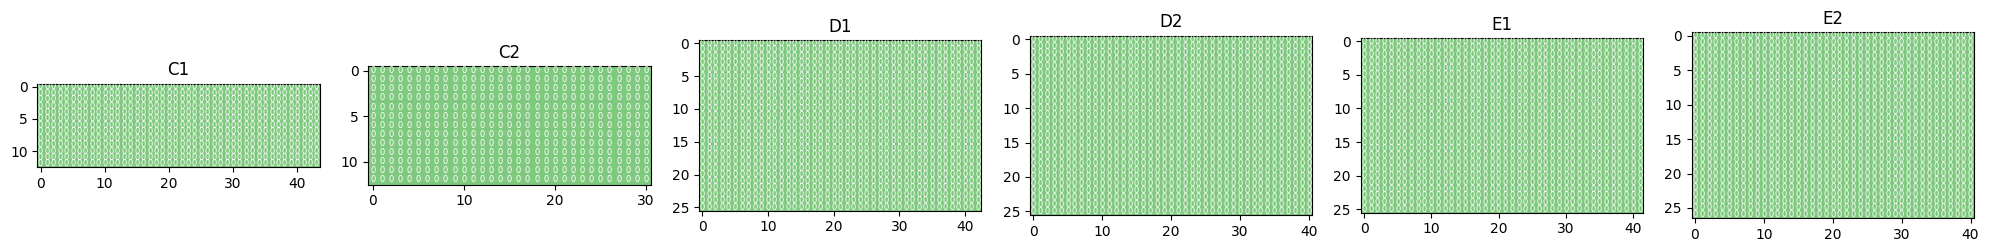

2024-02-11 00:00:00


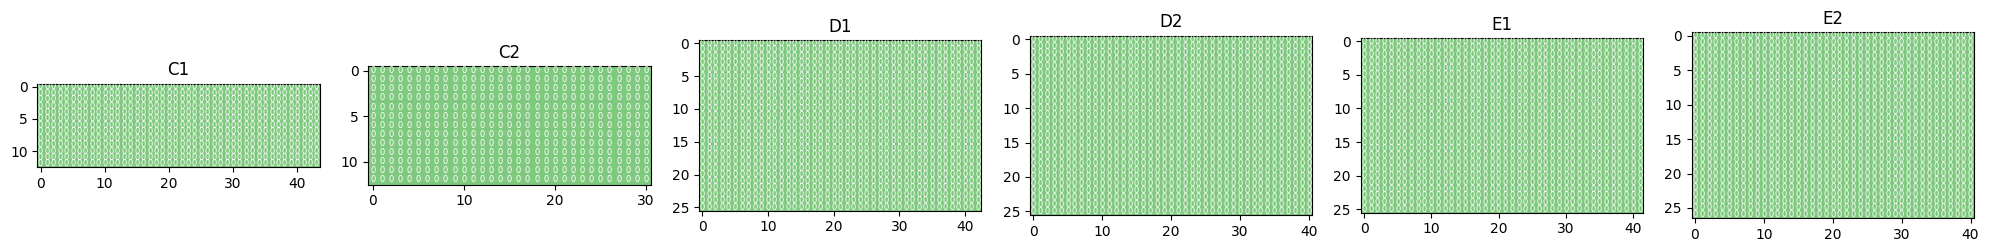

2024-02-21 00:00:00


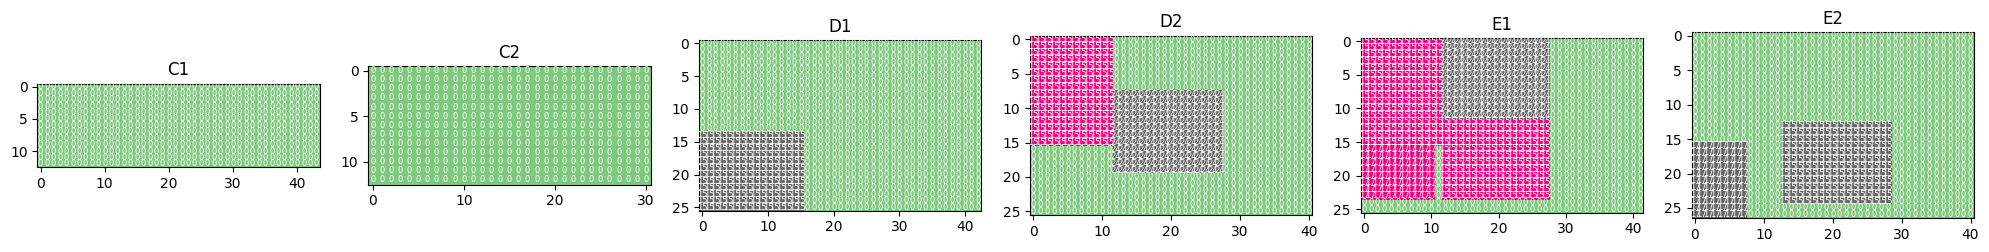

2024-03-02 00:00:00


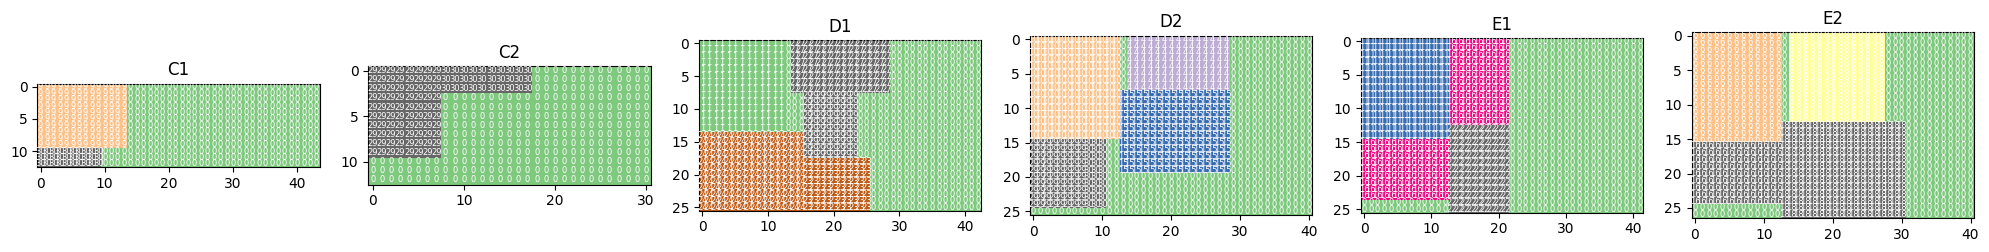

2024-03-12 00:00:00


In [ ]:
정반리스트 = 레이아웃달력.columns
for idx in range(0,100):
    if idx % 10 == 0:
        draw_layout_6_subplots(레이아웃달력, 정반리스트, idx)
    else:
        pass